In [1]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import src.helpers.model_helpers as mh
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# Load modeling dataset and the split indices
X_train, y_train, X_test, y_test = mh.load_model_dataset()

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/processed/hmda_2024_model.parquet


In [3]:
# Create and train model
random_forest_classifier = RandomForestClassifier(n_jobs=-1, bootstrap=True, random_state=42)

param_grid = {
    "n_estimators": randint(200, 800),
    "max_depth": [None, 10, 20, 40],
    "max_features": ["sqrt", 0.3, 0.5],
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 9),
    "class_weight": [None, "balanced"],
    "max_samples": [None, 0.5, 0.7, 0.9],
}

search = RandomizedSearchCV(
    random_forest_classifier,
    param_distributions=param_grid,
    n_iter=1, # Minimal for testing functionality.  Increase for real model training/eval.
    scoring="f1",
    cv=3,
    random_state=42,
    n_jobs=-1,
)

search.fit(X_train, y_train)

/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/Cellar/python@3.13/3.13.2/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setup

,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'class_weight': [None, 'balanced'], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 0.3, ...], 'max_samples': [None, 0.5, ...], ...}"
,n_iter,1
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [4]:
# Calculate F1 for validation
mh.output_cv_summary(search)

Best params: {'class_weight': None, 'max_depth': 40, 'max_features': 'sqrt', 'max_samples': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 220}
Best CV F1: 0.6601077805092509


In [5]:
# Calculate metrics
results, y_pred, y_prob = mh.calculate_test_metrics(search, X_test, y_test)

# Save metrics to CSV
mh.save_metrics_to_csv(results, "random_forest_metrics_csv")

# Display metrics
print("Test Performance:")
display(results)

Test Performance:


,Score
F1,0.681252
Accuracy,0.872568
Precision,0.848684
Recall,0.568998
ROC AUC,0.893326
PR AUC,0.792781


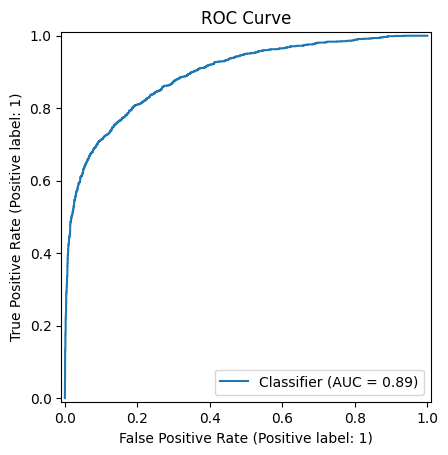

In [6]:
# ROC Curve
mh.draw_roc_curve(y_test, y_prob, "random_forest_roc")

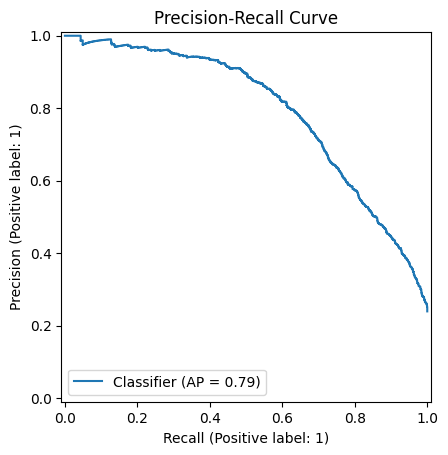

In [7]:
# PR Curve
mh.draw_pr_curve(y_test, y_prob, "random_forest_pr")